# Transfer Leaning with TensorFlow : Fine-tuning

In the previvious notebook, we covered transfer leaning feature ectraction , now its time to learn about new kinf of transfer learning: FINE TUNING

In [ ]:
!nvidia-smi

Wed Dec 27 14:17:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper function

In previous notebooks we crated a bunch of helper functions, now we could rewrite them all,however,this is tedious

Its a good idea to put functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere).

We've done this for some of the fucntions we've used previously here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-27 14:17:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-27 14:17:00 (96.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

**Note:** If you running this notebook in Google Colab, when it times out Colab will delete 'helper_functions.py' so youll have to redownload it if you want acces to your helper funcitons.

## Lets get some data

This time we're going to see how we can use the pretrained models within tf.keras.aplications and apply them to our own problem(revognizing images of food)

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-12-27 14:17:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   278MB/s    in 0.6s    

2023-12-27 14:17:05 (278 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
#Check how many images and sub directories in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMAGE_SIZE =(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMAGE_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
#Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
#See our example of batch data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[9.39438782e+01 6.99438782e+01 4.19438782e+01]
   [1.02260201e+02 7.92602005e+01 4.79285698e+01]
   [1.15076530e+02 9.21530609e+01 5.79234695e+01]
   ...
   [1.26076721e+02 1.08648193e+02 9.30001984e+01]
   [1.37882690e+02 1.22882698e+02 1.01882698e+02]
   [1.38515259e+02 1.26515259e+02 1.02515259e+02]]

  [[8.67602081e+01 6.07602043e+01 3.37602043e+01]
   [8.92091827e+01 6.61428604e+01 3.53418350e+01]
   [9.60000000e+01 7.30000000e+01 4.08571396e+01]
   ...
   [1.32341995e+02 1.13984894e+02 1.00469521e+02]
   [1.41076553e+02 1.26076561e+02 1.06801025e+02]
   [1.41285645e+02 1.26285645e+02 1.03285645e+02]]

  [[8.81377563e+01 6.21377563e+01 3.71377563e+01]
   [8.86836700e+01 6.26836739e+01 3.56836739e+01]
   [9.44030609e+01 7.11887741e+01 4.08316345e+01]
   ...
   [1.29811386e+02 1.11428764e+02 1.00500130e+02]
   [1.40928604e+02 1.23500023e+02 1.07571426e+02]
   [1.41285645e+02 1.24351997e+02 1.03510078e+02]]

  ...

  [[1.45433670e+02 1.21433662e+02 8.58621902e+01]
   [1

## Model 0: Building a trnsfer learning model using Keras Functional

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models


In [ ]:
# 1.Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2.Freeze the base model(so the underlying pre-trianed patterns arent updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you dont have for efficientnet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs in base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information,reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer") (x)

# 8. Combine inputs and outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9.Compile model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10.Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                 experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231227-102746
Epoch 1/5
24/24 [==============================] - 52s 2s/step - loss: 1.8850 - accuracy: 0.4187 - val_loss: 1.3547 - val_accuracy: 0.7171
Epoch 2/5
24/24 [==============================] - 45s 2s/step - loss: 1.1468 - accuracy: 0.7640 - val_loss: 0.9197 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 45s 2s/step - loss: 0.8690 - accuracy: 0.7827 - val_loss: 0.7320 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 45s 2s/step - loss: 0.6953 - accuracy: 0.8467 - val_loss: 0.6671 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 44s 2s/step - loss: 0.6022 - accuracy: 0.8627 - val_loss: 0.5907 - val_accuracy: 0.8520


In [ ]:
#Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.4057 - accuracy: 0.8804


[0.40573441982269287, 0.8804000020027161]

In [ ]:
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
#Summary of whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

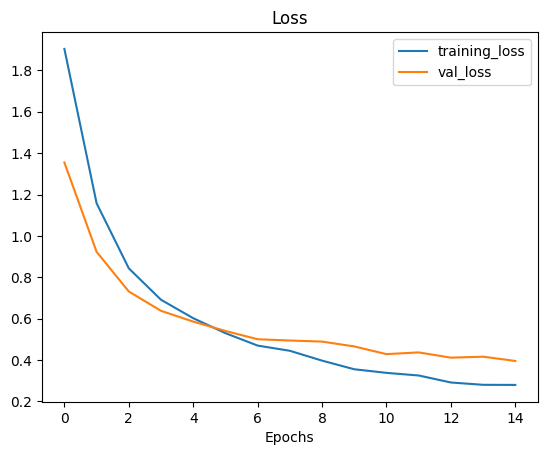

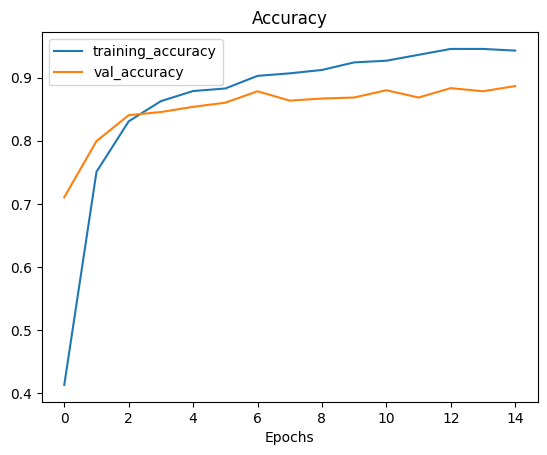

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feauture vector from a trained model

Lets demonstrate the Global Average Pooling 2D layer ....

We have a tensor after our model goues through 'base model' of shape(none,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into(none,1280).


Lets use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [ ]:
# Define the input shape
# We want smaller dimension to see what is going on in there :D
input_shape=(1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

# pass the random tensor through a gloabl average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"\n2D global average pooled random tensor:\n {global_average_pooled_tensor}")

#Check the shape of different tensors
print(f"\nShape of input tensor:\n {input_shape}")
print(f"\nShape of Gloabl Average Pooling 2D: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:
 (1, 4, 4, 3)

Shape of Gloabl Average Pooling 2D: (1, 3)


In [ ]:
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

 **Practice ***: Try to do same with the above two cells but this time use 'GlobalMaxPool2D'.. what will happen?

**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

In [ ]:
input_shape=(1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

# pass the random tensor through a gloabl average pooling 2D layer
global_max_2d = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"\n2D global max 2D random tensor:\n {global_max_2d}")

#Check the shape of different tensors
print(f"\nShape of input tensor:\n {input_tensor.shape}")
print(f"\nShape of Gloabl Average Pooling 2D: {global_max_2d.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max 2D random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor:
 (1, 4, 4, 3)

Shape of Gloabl Average Pooling 2D: (1, 3)


## Runing a series of transfer leanring experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a buch of experiments to find out:

1. 'model_1' - use feature extraction  transfer learning with 1% of the training data with data aumentation
2. 'model_2' - use feature extraction transfer learning with 10% of training data with data augmentation
3. 'model_3' - use fine tuning transfer learning on 10% of the training data with data augmentation
4. 'model_4' - use fine tuning transfer learning on 100% of the training data with data agumentation

**Note**: throughout all experiments the same test dataset will be used to evaluate our model.. this ensures consisteny acroos evaluation metrics

## Getting and preprocessing data for model_1

In [ ]:
#Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2023-12-27 14:18:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   217MB/s    in 0.6s    

2023-12-27 14:18:06 (217 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [ ]:
import tensorflow as tf

IMAGE_SIZE=(224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMAGE_SIZE,
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see benefits of doing this within the TensorFlow Data augmentation documentation :https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the befits of using data augmentation iside the model are:
* Preprocessing of images(augmeting them) happens on the GPU (MUCH FASTER) rather than CPU
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping rotations,zooms,etc
data_augmentation= keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255)# Kepp for models like ResNet50V2 but efficient dont need it
],name="data_augmentation")

### Visualize our data augmentation layer(and see what happen to our data)

10_food_classes_1_percent/train/ramen/3362012.jpg


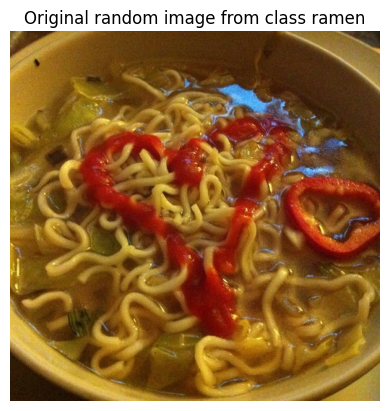

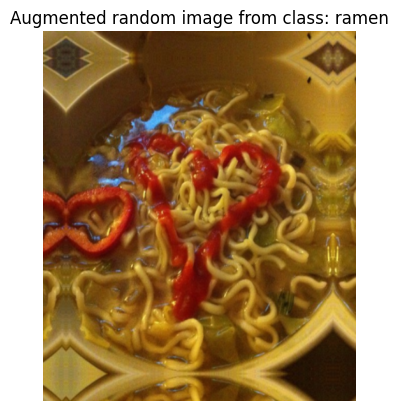

In [ ]:
# View random image and compare to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" +random_image
print(random_image_path)


#Read random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

#Lets plot augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer leraning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, frezzing the bas emodel layers
input_shape = (224,224,3)

#base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

#Add in data augmentation Sequetial model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmntation) and dont train it
x = base_model(x,training=False)

#Pool the output features of the base_model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

#Make a model using inputs and outputs
model_1 = keras.Model(inputs,outputs)

# compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps = int(0.25*len(test_data)),
                                #Track model training loss
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="1_percent_data_aug")])

24274472/24274472 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231227-101315
Epoch 1/5
3/3 [==============================] - 52s 22s/step - loss: 2.3704 - accuracy: 0.1000 - val_loss: 2.2912 - val_accuracy: 0.1497
Epoch 2/5
3/3 [==============================] - 44s 21s/step - loss: 2.2252 - accuracy: 0.1143 - val_loss: 2.1754 - val_accuracy: 0.1941
Epoch 3/5
3/3 [==============================] - 23s 11s/step - loss: 2.0054 - accuracy: 0.2571 - val_loss: 2.0747 - val_accuracy: 0.2533
Epoch 4/5
3/3 [==============================] - 23s 11s/step - loss: 1.8585 - accuracy: 0.3571 - val_loss: 1.9968 - val_accuracy: 0.3174
Epoch 5/5
3/3 [==============================] - 24s 11s/step - loss: 1.6764 - accuracy: 0.6000 - val_loss: 1.8966 - val_accuracy: 0.3882


In [ ]:
IMAGE_SIZE +(3,)

(224, 224, 3)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810 

In [ ]:
#Evaluate on full test data set
resaults_1_percent_data_aug = model_1.evaluate(test_data)
resaults_1_percent_data_aug

79/79 [==============================] - 81s 1s/step - loss: 1.8904 - accuracy: 0.4108


[1.890415072441101, 0.4108000099658966]

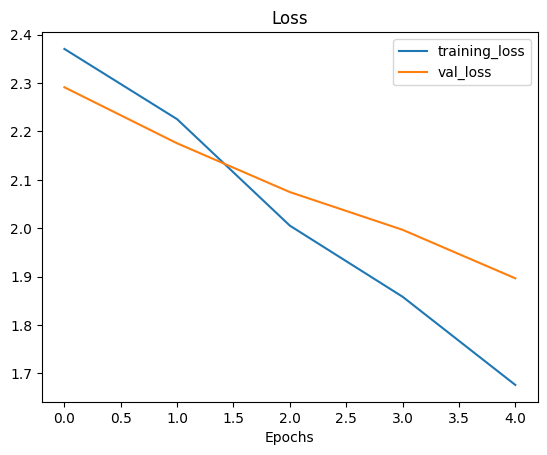

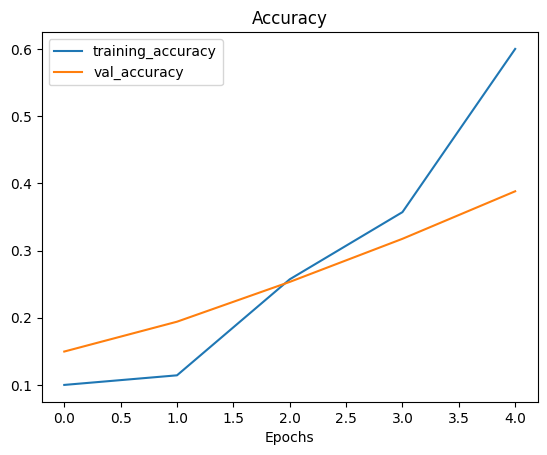

In [ ]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

In [ ]:
#Build data augmentation layer

data_augmentation_1 = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1/255.) if you using model such a ResNet50V2 you vill need this,Efficentnet have that build in theirself
],name="data_augmentation")

In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)


model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Fit the model

In [ ]:
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="model_2_10_percent"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_2_10_percent/20231227-141932
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0503 - accuracy: 0.2907
Epoch 1: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 46s 2s/step - loss: 2.0503 - accuracy: 0.2907 - val_loss: 1.5370 - val_accuracy: 0.6135
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4244 - accuracy: 0.6200
Epoch 2: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 28s 1s/step - loss: 1.4244 - accuracy: 0.6200 - val_loss: 1.0775 - val_accuracy: 0.7336
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1190 - accuracy: 0.7173
Epoch 3: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 23s 929ms/step - loss: 1.1190 - accuracy: 0.7173 - val_loss: 0.8632 - val_accuracy: 0.7993
Epoch 4/5
24/24 [===============

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

### Creating a model checkoint callback!!!

The model checkpoint callback intermediately saves our model (the full model or just weights) during training. This is usefull so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints/checkpoint.ckpt"

#Create a ModelCheckpoint callback that saves the models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 80s 1s/step - loss: 0.5772 - accuracy: 0.8544


[0.5771781206130981, 0.8543999791145325]

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 81s 1s/step - loss: 0.6657 - accuracy: 0.8252


[0.6657400131225586, 0.8252000212669373]

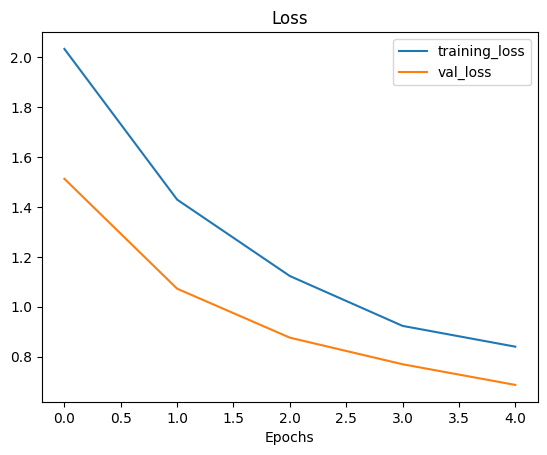

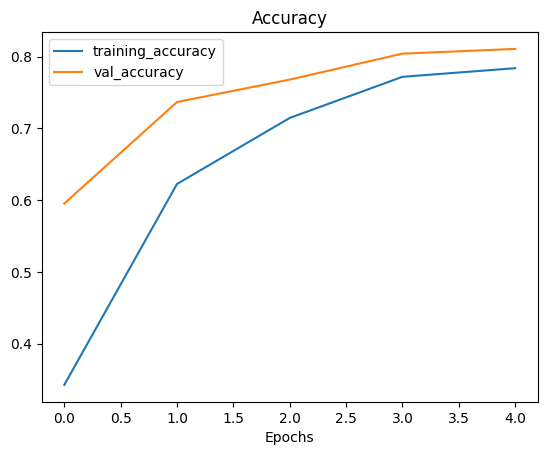

In [ ]:
plot_loss_curves(history_2)

## Loading and checkointed weights
Loading in chekpoint weights retuns a mmodel to a specific chekpoint

In [ ]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 82s 1s/step - loss: 0.6657 - accuracy: 0.8252


In [ ]:
results_10_percent_data_aug

[0.6657400131225586, 0.8252000212669373]

In [ ]:
loaded_weights_model_results

[0.6657400131225586, 0.8252000212669373]

In [ ]:
#If the results from our previviously evaluated model_2 match the loaded weights, everithing has worked
results_10_percent_data_aug == loaded_weights_model_results

True

In [ ]:
# Check if loaded model results are very close to our previous non-model(my profesor got 2 very very very similar results, and now he is doing this function np.isclose where function dete the small difference(have the tolerance))
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))


array([ True,  True])

In [ ]:
# I got 0 but difference in my proffesor's cell is 0.00000000178
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine tuning and existing model on 10% percent of the data

>**Note** Fine-tuning ussualy works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [ ]:
# layers in laoded model
model_2.layers


In [ ]:
# Are this layers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7d7dfe16ef80> True
<keras.src.engine.sequential.Sequential object at 0x7d7e10342770> True
<keras.src.engine.functional.Functional object at 0x7d7e0333f040> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7d7dfe16f6a0> True
<keras.src.layers.core.dense.Dense object at 0x7d7e0333eaa0> True


In [ ]:
#What layer s are in our base model and are they trainable(EfficientnetB0)
for i,layer in enumerate(model_2.layers[2].layers):
  print(layer.name,layer.trainable)

input_2 False
rescaling_1 False
normalization_1 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False
block3b_project_conv False
block3b_project_bn False
block3b_drop False
block3b_add False
block4a_expand_conv False
block4a_expand_bn False
block4a_expand_activation False
block4a_dwconv2 False
block4a_bn False
block4a_activation False
block4a_se_squeeze False
block4a_se_reshape False
blo

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [ ]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

> **Note** when using fine tuning it sbest practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. but a good rule of tumb is at least 10x(though different sources will claim other values)

A good resource for information is the UMLFit paper

In [ ]:
# Check which layers are tunable(trainable)
#for layer_number,layer in enumerate(model_2_base_model.layers): # Moze i model_2_base_model.layers
#  print(layer_number,layer.name,layer.trainable)

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Now we unforezn some layers closer to the top, how many trainable layers are there
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block6h_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.00207604,  0.01300672,  0.02047416, ..., -0.02240255,
           -0.07708141, -0.00094655],
          [-0.06357138,  0.0959678 , -0.05430871, ..., -0.01352078,
           -0.05987524, -0.11093444],
          [ 0.0068749 , -0.04681807, -0.01513974, ...,  0.03073284,
           -0.01280731,  0.03616464],
          ...,
          [ 0.11381665,  0.00804447, -0.05432149, ...,  0.08015257,
           -0.06561387, -0.05522665],
          [-0.12468243,  0.06938899, -0.07634895, ...,  0.01121222,
           -0.0128268 ,  0.10406019],
          [-0.04722364,  0.10557885,  0.16247186, ...,  0.04582691,
            0.01228108, -0.04941604]]]], dtype=float32)>,
 <tf.Variable 'block6h_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([ 0.04594925,  2.5461788 , -1.426646  , -0.7885664 , -0.24730209,
        -0.5630991 , -0.6161863 , -0.4029834 , -1.4444699 , -1.0481553 ,
        -0.21704195,

## Now its time to fine tune our model

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 expect with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_2.epoch[-1], #start training from previous model last epoch(history_2=previous model)
                                               callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                        experiment_name= "10_percent_fine_tuning_last_10_layers")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuning_last_10_layers/20231227-114412
Epoch 5/10
24/24 [==============================] - 53s 2s/step - loss: 0.5441 - accuracy: 0.8453 - val_loss: 0.4819 - val_accuracy: 0.8339
Epoch 6/10
24/24 [==============================] - 51s 2s/step - loss: 0.5208 - accuracy: 0.8320 - val_loss: 0.5045 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 51s 2s/step - loss: 0.4819 - accuracy: 0.8440 - val_loss: 0.4750 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 52s 2s/step - loss: 0.4433 - accuracy: 0.8760 - val_loss: 0.5327 - val_accuracy: 0.8339
Epoch 9/10
24/24 [==============================] - 51s 2s/step - loss: 0.4260 - accuracy: 0.8627 - val_loss: 0.5332 - val_accuracy: 0.8273
Epoch 10/10
24/24 [==============================] - 51s 2s/step - loss: 0.3951 - accuracy: 0.8640 - val_loss: 0.5277 - val_accuracy: 0.8224


In [ ]:
results_fine_tuning = model_2.evaluate(test_data)

79/79 [==============================] - 90s 1s/step - loss: 0.4632 - accuracy: 0.8440


In [ ]:
results_10_percent_data_aug

[0.6657400131225586, 0.8252000212669373]

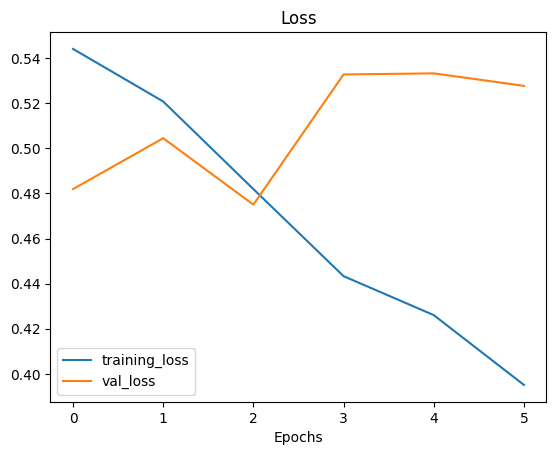

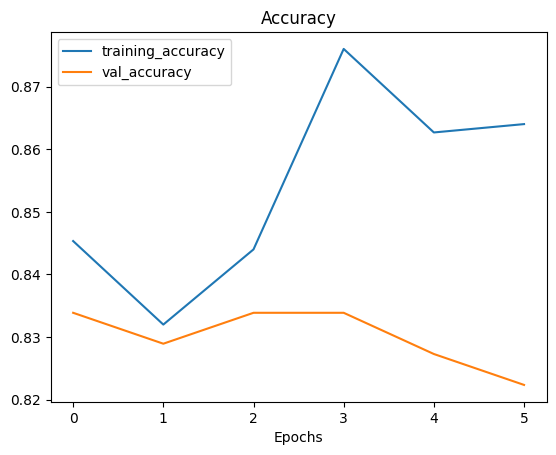

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

The 'plot_loss_curves' function works great with models which have only been fit once, however we want something to compare one series of running 'fit()' with another (e.g. before and after fine-tuning)

In [ ]:
# lets create a function to compare training histories
def comprate_historys (original_history,new_history,initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """

  #Get original history
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # make a plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="training accuracy")
  plt.plot(total_val_acc,label="training validation accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="start fine tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validaiton accuracy")


  # make a plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss,label="training loss")
  plt.plot(total_val_loss,label="training validation loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="start fine tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validaiton loss")


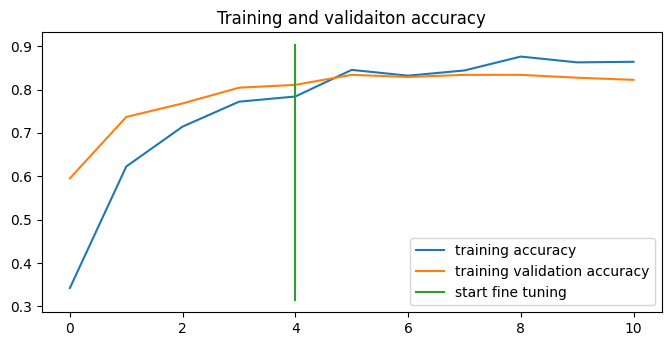

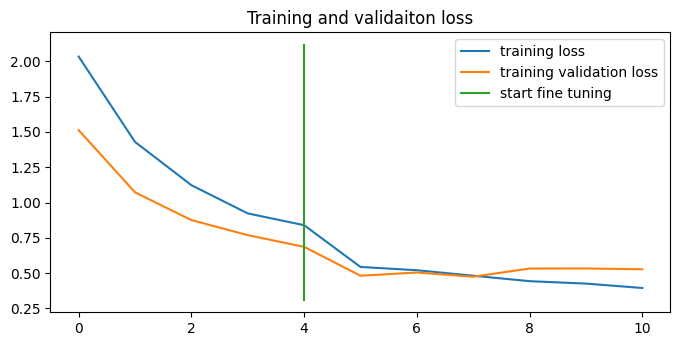

In [ ]:
comprate_historys(history_2,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

### Model 4: Fine tuning and eexisting model on all of the data

In [ ]:
# Download and unzip data 10 classes of Food101 with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-12-27 14:18:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   259MB/s    in 1.9s    

2023-12-27 14:18:55 (259 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [ ]:
import tensorflow as tf

IMAGE_SIZE =(224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMAGE_SIZE,
                                                                                 batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've using for previous experience

In [ ]:
# Evaluate model 2 (this is fine tunde on 10% of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 94s 1s/step - loss: 0.4632 - accuracy: 0.8440


[0.46319088339805603, 0.843999981880188]

In [ ]:
results_fine_tuning

[0.4631907641887665, 0.843999981880188]

To train a fine tuning model(model_4 ) we need to revert model_2 back to its feature extraction weights

In [ ]:
# Load weights from checkpoint, that way we can fine tune from same stage
# the 10 percent data model was fine tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Lets evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 90s 1s/step - loss: 0.6565 - accuracy: 0.8308


[0.6564672589302063, 0.8307999968528748]

In [ ]:
#Chcek to see if our model_2 has been reverted back to our feature extractoin results
results_10_percent_data_aug

[0.6657400131225586, 0.8252000212669373]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint (Model 2).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (Model 3).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (Model 4).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Check NOW, because if one layer is True whole efficientnet layer will be true
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20231227-142310
Epoch 5/10
235/235 [==============================] - 162s 644ms/step - loss: 0.7154 - accuracy: 0.7712 - val_loss: 0.3712 - val_accuracy: 0.8618
Epoch 6/10
235/235 [==============================] - 109s 463ms/step - loss: 0.5987 - accuracy: 0.8076 - val_loss: 0.2897 - val_accuracy: 0.8898
Epoch 7/10
235/235 [==============================] - 96s 406ms/step - loss: 0.5438 - accuracy: 0.8251 - val_loss: 0.2735 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 81s 341ms/step - loss: 0.5142 - accuracy: 0.8341 - val_loss: 0.2636 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 71s 302ms/step - loss: 0.4727 - accuracy: 0.8520 - val_loss: 0.2601 - val_accuracy: 0.8997
Epoch 10/10
235/235 [==============================] - 65s 274ms/step - loss: 0.4617 - accuracy: 0.8484 - val_loss: 0.2423 - val_accuracy: 0.9178


In [ ]:
# Lets evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 71ms/step - loss: 0.2718 - accuracy: 0.9104


[0.2718343436717987, 0.9103999733924866]

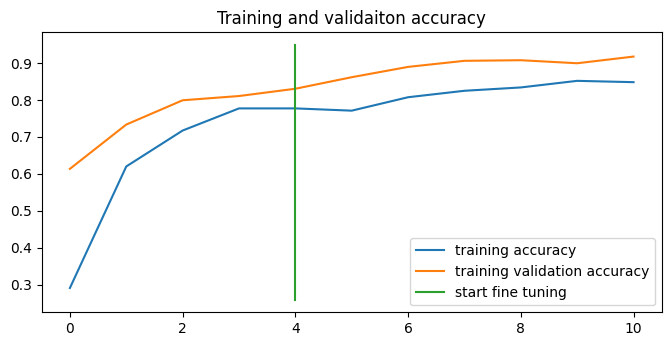

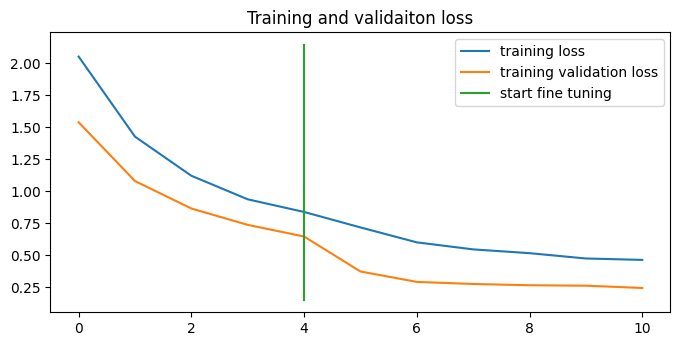

In [ ]:
# How did fine-tuning go with more data?
comprate_historys(original_history=history_2,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard
 TensorBoard is not able to use. I can't do that

In [ ]:
#!tensorboard dev upload --logdir ./transfer_learning \
#  --name "Transfer learning eperiments with 10 Food101 Classes"\
#  -- description "A series of dfferent transfer learning experimenrs with varying amounts of data with fine tuning"\
#  --one_shot # exits the uploder once its finished
